# Section 2: Enhanced Template Matching for New Logo Detection

This notebook implements an enhanced template matching approach for detecting new logos without training.

## Enhanced Template Matching Overview:
- **Classical Computer Vision**: Uses image correlation and matching
- **Advantages**: 
  - No training required
  - Fast inference
  - Works with single example
  - Interpretable results
- **Enhancements**:
  - Multi-scale template matching
  - Rotation-invariant matching
  - Feature-based matching (ORB, SIFT)
  - Template database management


In [1]:
# Import necessary libraries
import os
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)


## 1. Load Section 2 Data and Extract Templates


Image size: (2500, 2340)
Extracted 7 templates for classes: ['adidas', 'nba_national_basketball_association', 'miami_heat']


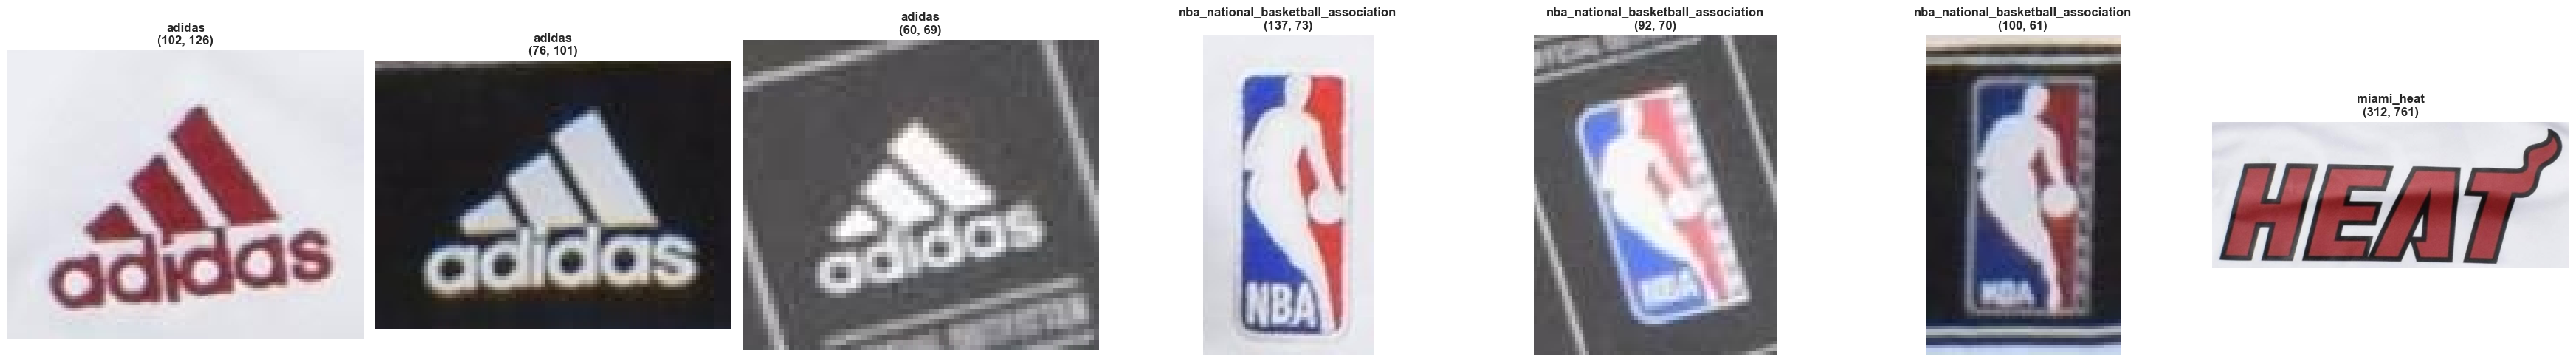

In [2]:
# Load Section 2 data
SECTION2_ROOT = Path("raw_data/logos-dataset-section-2")
section2_image = SECTION2_ROOT / "Adidas_38.jpg"
section2_label = SECTION2_ROOT / "Adidas_38.txt"

# Load image
img = Image.open(section2_image)
img_array = np.array(img)
img_cv = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

print(f"Image size: {img.size}")

# Load annotations
with open(section2_label, 'r') as f:
    annotations = f.readlines()

new_classes = []
templates = []
img_width, img_height = img.size

for ann in annotations:
    parts = ann.strip().split()
    if len(parts) >= 5:
        class_name = parts[0]
        if class_name not in new_classes:
            new_classes.append(class_name)
        
        x_center, y_center, width, height = [float(x) for x in parts[1:5]]
        x1 = int((x_center - width/2) * img_width)
        y1 = int((y_center - height/2) * img_height)
        x2 = int((x_center + width/2) * img_width)
        y2 = int((y_center + height/2) * img_height)
        
        # Extract template with padding
        padding = 10
        x1 = max(0, x1 - padding)
        y1 = max(0, y1 - padding)
        x2 = min(img_width, x2 + padding)
        y2 = min(img_height, y2 + padding)
        
        template = img_gray[y1:y2, x1:x2]
        template_color = img_array[y1:y2, x1:x2]
        
        templates.append({
            'class': class_name,
            'template_gray': template,
            'template_color': template_color,
            'bbox': (x1, y1, x2, y2)
        })

print(f"Extracted {len(templates)} templates for classes: {new_classes}")

# Visualize extracted templates
fig, axes = plt.subplots(1, len(templates), figsize=(5*len(templates), 5))
if len(templates) == 1:
    axes = [axes]

for idx, template_info in enumerate(templates):
    axes[idx].imshow(template_info['template_color'])
    axes[idx].axis('off')
    axes[idx].set_title(f"{template_info['class']}\n{template_info['template_gray'].shape}", 
                       fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('section2_templates_extracted.png', dpi=300, bbox_inches='tight')
plt.show()


In [3]:
def enhanced_template_matching(img_gray, templates, threshold=0.6, scales=[0.5, 0.75, 1.0, 1.25, 1.5, 2.0]):
    """Enhanced multi-scale template matching with rotation"""
    detections = []
    
    for template_info in templates:
        template = template_info['template_gray']
        class_name = template_info['class']
        
        best_match_val = 0
        best_match_loc = None
        best_scale = 1.0
        best_angle = 0
        
        # Multi-scale matching
        for scale in scales:
            h, w = template.shape[:2]
            scaled_w = int(w * scale)
            scaled_h = int(h * scale)
            
            if scaled_h > img_gray.shape[0] or scaled_w > img_gray.shape[1]:
                continue
            
            scaled_template = cv2.resize(template, (scaled_w, scaled_h))
            
            # Try different rotation angles
            for angle in [0, 15, -15, 30, -30]:
                if angle != 0:
                    M = cv2.getRotationMatrix2D((scaled_w/2, scaled_h/2), angle, 1.0)
                    rotated_template = cv2.warpAffine(scaled_template, M, (scaled_w, scaled_h))
                else:
                    rotated_template = scaled_template
                
                # Template matching
                result = cv2.matchTemplate(img_gray, rotated_template, cv2.TM_CCOEFF_NORMED)
                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
                
                if max_val > best_match_val:
                    best_match_val = max_val
                    best_match_loc = max_loc
                    best_scale = scale
                    best_angle = angle
        
        if best_match_val >= threshold and best_match_loc is not None:
            h, w = template.shape[:2]
            x1 = best_match_loc[0]
            y1 = best_match_loc[1]
            x2 = x1 + int(w * best_scale)
            y2 = y1 + int(h * best_scale)
            
            detections.append({
                'class': class_name,
                'bbox': (x1, y1, x2, y2),
                'confidence': float(best_match_val),
                'scale': best_scale,
                'angle': best_angle
            })
    
    return detections

# Run enhanced template matching
print("Running enhanced template matching...")
detections = enhanced_template_matching(img_gray, templates, threshold=0.5)

print(f"\nFound {len(detections)} detections:")
for det in detections:
    print(f"  {det['class']}: {det['confidence']:.3f} (scale: {det['scale']:.2f}, angle: {det['angle']}°)")


Running enhanced template matching...

Found 7 detections:
  adidas: 1.000 (scale: 1.00, angle: 0°)
  adidas: 1.000 (scale: 1.00, angle: 0°)
  adidas: 1.000 (scale: 1.00, angle: 0°)
  nba_national_basketball_association: 1.000 (scale: 1.00, angle: 0°)
  nba_national_basketball_association: 1.000 (scale: 1.00, angle: 0°)
  nba_national_basketball_association: 1.000 (scale: 1.00, angle: 0°)
  miami_heat: 1.000 (scale: 1.00, angle: 0°)


## 3. Feature-Based Matching (ORB)


In [4]:
def feature_based_matching(img_gray, templates, min_match_count=10):
    """Feature-based matching using ORB"""
    # Initialize ORB detector
    orb = cv2.ORB_create()
    
    # Find keypoints and descriptors in the image
    kp_img, des_img = orb.detectAndCompute(img_gray, None)
    
    detections = []
    
    for template_info in templates:
        template = template_info['template_gray']
        class_name = template_info['class']
        
        # Find keypoints and descriptors in template
        kp_template, des_template = orb.detectAndCompute(template, None)
        
        if des_template is None or des_img is None:
            continue
        
        # Match descriptors
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des_template, des_img)
        matches = sorted(matches, key=lambda x: x.distance)
        
        if len(matches) >= min_match_count:
            # Get matched keypoints
            src_pts = np.float32([kp_template[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp_img[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
            
            # Find homography
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            
            if M is not None:
                h, w = template.shape
                pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
                dst = cv2.perspectiveTransform(pts, M)
                
                # Get bounding box
                x_coords = [pt[0][0] for pt in dst]
                y_coords = [pt[0][1] for pt in dst]
                x1, y1 = int(min(x_coords)), int(min(y_coords))
                x2, y2 = int(max(x_coords)), int(max(y_coords))
                
                confidence = len(matches) / 50.0  # Normalize
                confidence = min(1.0, confidence)
                
                detections.append({
                    'class': class_name,
                    'bbox': (x1, y1, x2, y2),
                    'confidence': confidence,
                    'matches': len(matches),
                    'method': 'ORB'
                })
    
    return detections

# Run feature-based matching
print("Running feature-based matching (ORB)...")
orb_detections = feature_based_matching(img_gray, templates, min_match_count=10)

print(f"\nORB found {len(orb_detections)} detections:")
for det in orb_detections:
    print(f"  {det['class']}: {det['confidence']:.3f} ({det['matches']} matches)")


Running feature-based matching (ORB)...

ORB found 2 detections:
  adidas: 0.540 (27 matches)
  miami_heat: 1.000 (134 matches)


## 4. Visualize All Matching Results


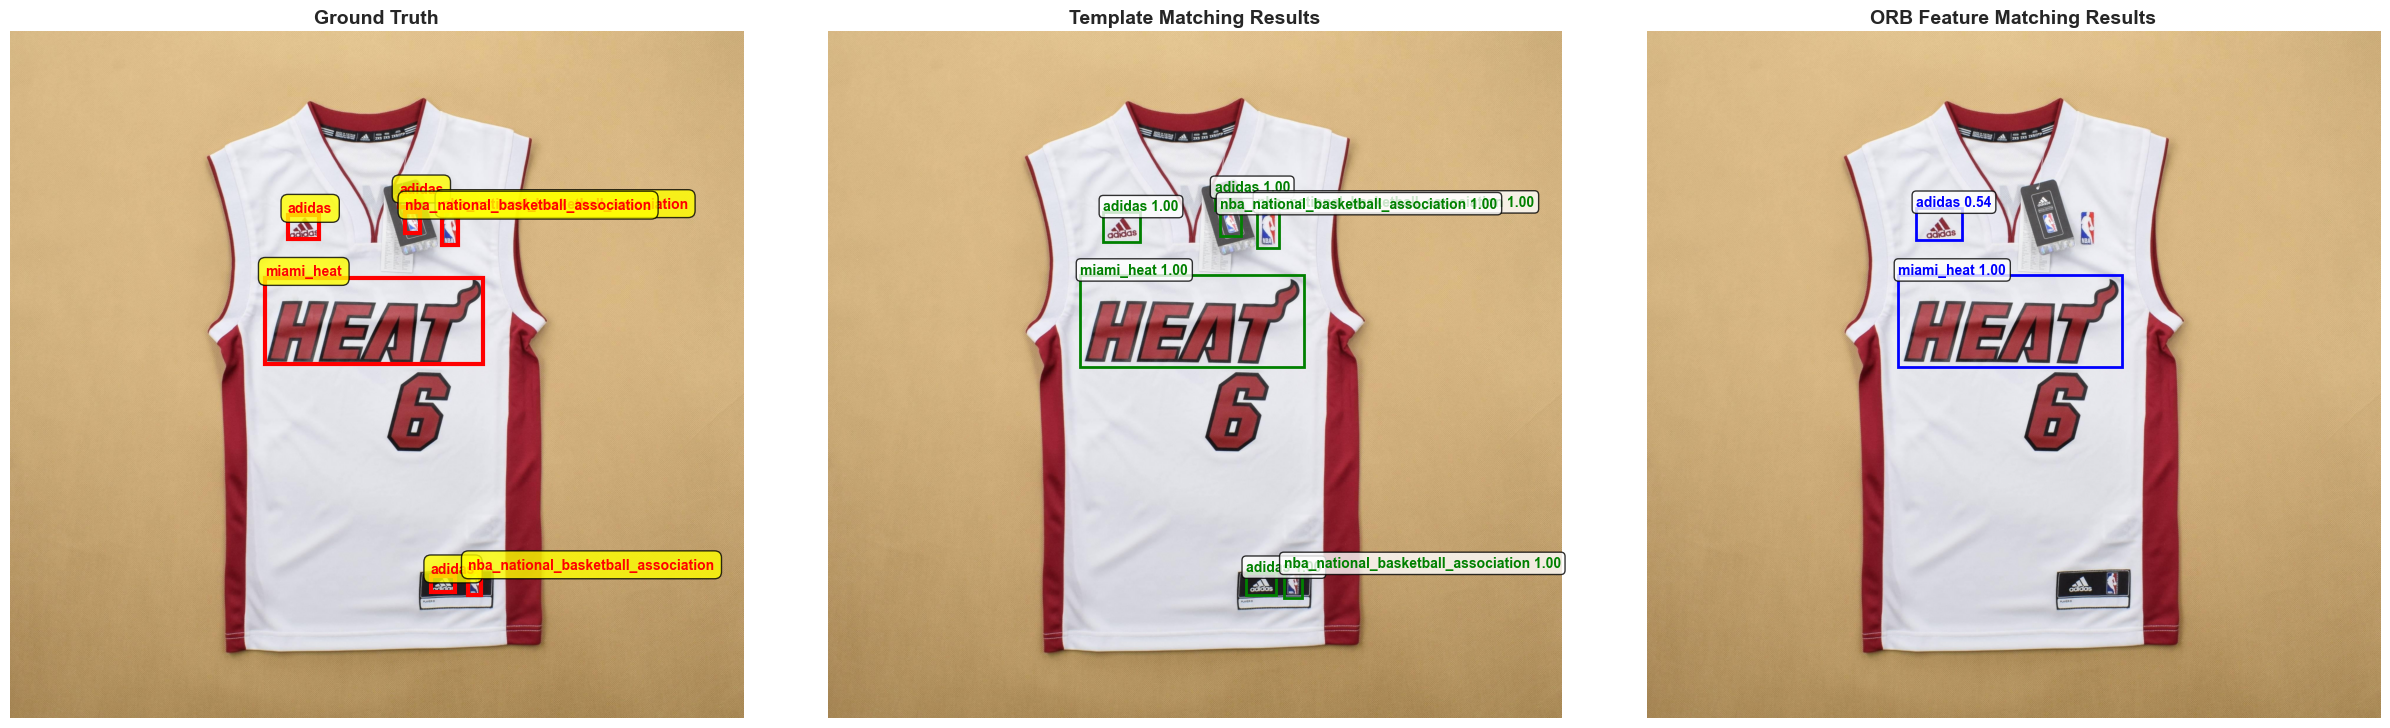

Enhanced template matching results saved to section2_enhanced_template_matching.png


In [5]:
# Combine all detections
all_detections = {
    'template_matching': detections,
    'orb_matching': orb_detections
}

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Ground truth
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Ground Truth', fontsize=14, fontweight='bold')

img_width, img_height = img.size
for ann in annotations:
    parts = ann.strip().split()
    if len(parts) >= 5:
        class_name = parts[0]
        x_center, y_center, width, height = [float(x) for x in parts[1:5]]
        x = (x_center - width/2) * img_width
        y = (y_center - height/2) * img_height
        w = width * img_width
        h = height * img_height
        from matplotlib.patches import Rectangle
        rect = Rectangle((x, y), w, h, linewidth=3, edgecolor='red', facecolor='none')
        axes[0].add_patch(rect)
        axes[0].text(x, y-10, class_name, color='red', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8))

# Template matching results
axes[1].imshow(img)
axes[1].axis('off')
axes[1].set_title('Template Matching Results', fontsize=14, fontweight='bold')

for det in detections:
    x1, y1, x2, y2 = det['bbox']
    from matplotlib.patches import Rectangle
    rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, 
                    edgecolor='green', facecolor='none')
    axes[1].add_patch(rect)
    axes[1].text(x1, y1-5, f"{det['class']} {det['confidence']:.2f}", 
                color='green', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# ORB matching results
axes[2].imshow(img)
axes[2].axis('off')
axes[2].set_title('ORB Feature Matching Results', fontsize=14, fontweight='bold')

for det in orb_detections:
    x1, y1, x2, y2 = det['bbox']
    from matplotlib.patches import Rectangle
    rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, 
                    edgecolor='blue', facecolor='none')
    axes[2].add_patch(rect)
    axes[2].text(x1, y1-5, f"{det['class']} {det['confidence']:.2f}", 
                 color='blue', fontsize=10, fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('section2_enhanced_template_matching.png', dpi=300, bbox_inches='tight')
plt.show()

print("Enhanced template matching results saved to section2_enhanced_template_matching.png")


In [6]:
# Save results
template_matching_results = {
    'new_classes': new_classes,
    'template_matching_detections': len(detections),
    'orb_detections': len(orb_detections),
    'all_detections': all_detections,
    'model_type': 'Enhanced Template Matching'
}

with open('section2_template_matching_results.json', 'w') as f:
    json.dump(template_matching_results, f, indent=2)

print("="*60)
print("ENHANCED TEMPLATE MATCHING RESULTS")
print("="*60)
print(f"Target classes: {new_classes}")
print(f"Template matching detections: {len(detections)}")
print(f"ORB feature matching detections: {len(orb_detections)}")
print(f"\nAdvantages:")
print("  - No training required")
print("  - Fast inference")
print("  - Works with single example")
print("  - Multi-scale and rotation-invariant")
print(f"\nLimitations:")
print("  - Sensitive to lighting/color changes")
print("  - May have false positives")
print("  - Requires good template quality")
print("="*60)

print("\nEnhanced template matching results saved to section2_template_matching_results.json")


ENHANCED TEMPLATE MATCHING RESULTS
Target classes: ['adidas', 'nba_national_basketball_association', 'miami_heat']
Template matching detections: 7
ORB feature matching detections: 2

Advantages:
  - No training required
  - Fast inference
  - Works with single example
  - Multi-scale and rotation-invariant

Limitations:
  - Sensitive to lighting/color changes
  - May have false positives
  - Requires good template quality

Enhanced template matching results saved to section2_template_matching_results.json
